In [1]:
from typing import List

import aesara.tensor as aet
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from scipy import linalg, spatial, special
from scipy.special import expit as logistic
from scipy.special import logit

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [3]:
polls = pd.read_csv(
    "../../data/polls_1st_round/tour1_complet_unitedfl.csv",
    index_col=0,
    parse_dates=["dateelection", "date"],
)
polls = (
    polls[
        (polls.dateelection == "2017-04-23")
        & (polls.date >= "2017-01")
        & (polls.sondage != "result")
    ]
    .drop(
        [
            "type",
            "dateelection",
            "abstention",
            "undecided",
        ],
        axis=1,
    )
    .set_index(["date", "sondage", "samplesize"])
    .sort_index()
)

In [4]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
}

In [5]:
# compute "other" category
polls = polls.rename(
    columns={col: col.split("nb")[1] for col in polls if col.startswith("nb")}
)[COORDS["parties"]]
polls["other"] = 100 - polls.sum(1)
polls = polls.reset_index(level="samplesize")

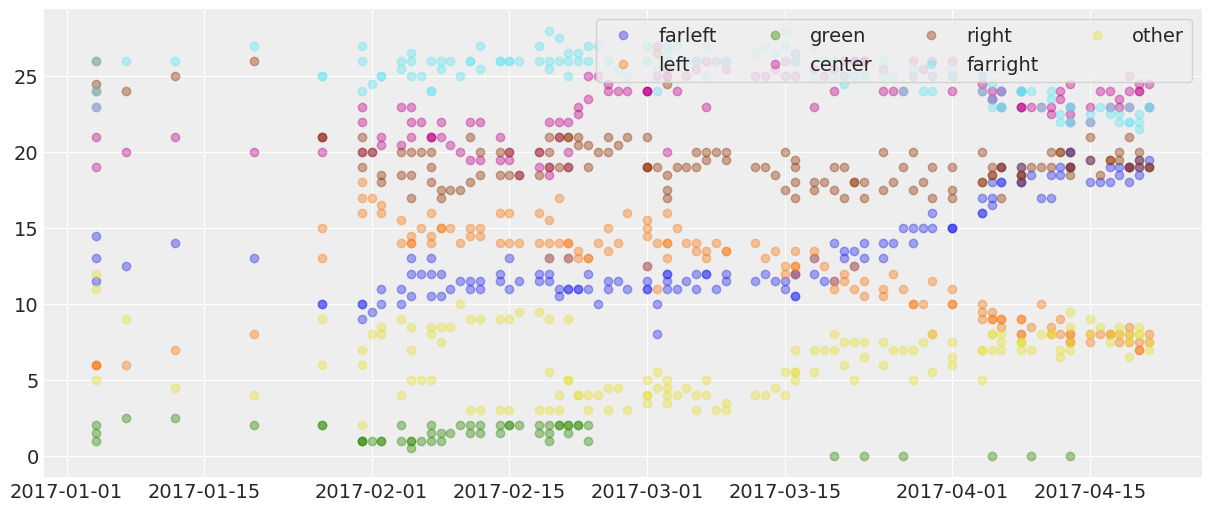

In [6]:
data = polls.reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
for p in COORDS["parties_complete"]:
    ax.plot(data["date"], data[p], "o", label=p, alpha=0.4)
ax.legend(ncol=4, frameon=True, loc="upper right");

In [7]:
# cast as multinomial obs
polls[COORDS["parties_complete"]] = (
    (polls[COORDS["parties_complete"]] / 100)
    .mul(polls["samplesize"], axis=0)
    .round()
    .fillna(0)
    .astype(int)
)
polls["samplesize"] = polls[COORDS["parties_complete"]].sum(1)
polls = polls.reset_index()
polls

date sondage  samplesize  farleft  left  green  center  right  \
0   2017-01-04   Elabe         996      144    60     15     229    259   
1   2017-01-04   Elabe         995      129    60     10     209    239   
2   2017-01-04    Ifop        1472      169    88     29     280    361   
3   2017-01-07     BVA         946      118    57     24     189    227   
4   2017-01-12   Ipsos       15919     2229  1114    398    3343   3980   
..         ...     ...         ...      ...   ...    ...     ...    ...   
139 2017-04-20   Elabe        1196      233    84      0     287    239   
140 2017-04-20    Ifop        1901      352   133      0     466    370   
141 2017-04-20   Ipsos        1400      266   105      0     336    266   
142 2017-04-21     BVA        1134      221    91      0     261    215   
143 2017-04-21   Odoxa         667      127    50      0     163    127   

     farright  other  
0         239     50  
1         229    119  
2         383    162  
3         246     85  
4        4139    716  
..        ...    ...  
139       257     96  
140       428    152  
141       308    119  
142       261     85  
143       153     47  

[144 rows x 10 columns]

In [8]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date"""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "D")

    return np.asarray(t)

## GP approximation

In [9]:
def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)

    return np.eye(N) - 2 * np.outer(v, v)

In [10]:
def make_centered_gp_eigendecomp(
    time: np.ndarray,
    lengthscales: List[float],
    variance_limit: float = 0.95,
    metric: str = "euclidean",
    zerosum: bool = False,
):
    """
    Decompose the GP into eigen values and eigen vectors.

    Parameters
    ----------
    time: np.ndarray
        Array containing the time points of observations.
    lengthscales: List[float]
        Length scale parameter of the GP. Set in the ``config`` dictionary.
    variance_limit: float, defaults to 0.95
        Controls how many of the eigen vectors of the GP are used. So, if
        ``variance_limit=1``, all eigen vectors are used.
    metric: str, defaults to "euclidean"
        Experimental. Used to estimate the distance between ranges and rows.
    zerosum: bool, default=False
        Constrain all basis functions to sum(basis) = 0.

    Notes
    -----
    Makes sure that the GP effect sums to zero across plots of each field.
    """

    ## Construct covariance matrix
    X = time[:, None]
    X_norm = X / np.array(lengthscales)
    dists = spatial.distance.cdist(X_norm, X_norm, metric=metric)
    cov = np.exp(-(dists ** 2) / 2)

    if zerosum:
        Q = make_sum_zero_hh(len(cov))
        D = np.eye(len(cov))
        D[0, 0] = 0

        # 1) Transform the covariance matrix so that the first entry
        # is the mean: A = Q @ cov @ Q.T
        # 2) Project onto the subspace without the mean: B = D @ A @ D
        # 3) Transform the result back to the original space: Q.T @ B @ Q
        cov = Q.T @ D @ Q @ cov @ Q.T @ D @ Q

    vals, vecs = linalg.eigh(cov)
    n_eigs = ((vals[::-1].cumsum() / vals.sum()) > variance_limit).nonzero()[0][0]

    return vecs[:, -n_eigs:] * np.sqrt(vals[-n_eigs:])

In [18]:
observed_days_idx = dates_to_idx(polls.date).astype(int)
estimated_days = dates_to_idx(
    pd.date_range(polls.date[0], "2017-06-23", freq="D")
).astype(int)
pollster_id, pollsters = polls["sondage"].factorize(sort=True)

gp_basis = make_centered_gp_eigendecomp(
    estimated_days,
    lengthscales=2.0,
)

COORDS["pollsters"] = pollsters
COORDS["observed_days"] = polls.date
COORDS["estimated_days"] = pd.date_range(polls.date[0], "2017-06-23", freq="D")
COORDS["gp_basis"] = pd.RangeIndex(gp_basis.shape[-1])
COORDS["observations"] = polls.set_index(["date", "sondage", "samplesize"]).index

In [30]:
mean_prior_p = arviz.from_netcdf("fundamentals_preds.nc").posterior.mean(("samples", "regions"))["x"].data
prior_cum_p = np.cumsum(mean_prior_p)
prior_logit_p = logit(prior_cum_p)[:-1]

In [ ]:
    n_cutpoints = len(COORDS["parties"])
    cut_base = pm.Normal("cut_base", mu=-1, sigma=3)
    cut_diffs = pm.HalfNormal("cut_diffs", sigma=2 / n_cutpoints, shape=n_cutpoints - 1)

    cutpoints = pm.Deterministic(
        "cutpoints",
        aet.concatenate([[cut_base], cut_base + cut_diffs.cumsum()]),
        dims="parties",
    )
    
    initval = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=initval,
        sigma=3.0,
        initval=initval,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

In [33]:
with pm.Model(coords=COORDS) as m_simple:
    n_parties = len(COORDS["parties"])
#    intercept_base = pm.Normal("intercept_base", mu=-1, sigma=1)
 #   intercept_diffs = pm.HalfNormal(
  #      "intercept_diffs", sigma=2 / n_parties, shape=n_parties - 1
   # )
    #intercepts = pm.Deterministic(
     #   "intercepts",
      #  aet.concatenate([[intercept_base], intercept_base + intercept_diffs.cumsum()]),
       # dims="parties",
    #)
    intercepts = pm.Normal(
        "intercepts",
        mu=prior_logit_p,
        sigma=1.0,
        initval=prior_logit_p,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )

    trend_base = pm.Normal("trend_base", mu=-1, sigma=1)
    trend_diffs = pm.HalfNormal("trend_diffs", sigma=2 / n_parties, shape=n_parties - 1)
    trends = pm.Deterministic(
        "long_term_trends",
        aet.concatenate([[trend_base], trend_base + trend_diffs.cumsum()]),
        dims="parties",
    )

    gps = []
    for p, init_val in zip(COORDS["parties"], np.arange(len(COORDS["parties"])) - 2.5):
        #        intercept = pm.Normal(f"intercept_{p}", initval=init_val)
        #       trend = pm.Normal(f"long_term_trend_{p}", initval=init_val)

        sd = pm.HalfNormal(f"time_weight_{p}", 0.5)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")
        gps.append(gp_party)

    #        regression = pm.Deterministic(f"regression_{p}", intercept + trend * estimated_days + gp_party, dims="estimated_days")

    #       print(f"intercept_{p}: {intercept.eval().round(2)}")
    #        print(f"trend_{p}: {trend.eval().round(2)}\n")
    #       print(f"gp_party_{p}: {gp_party.eval().round(2)}\n")
    #        print(f"regression_{p}: {regression.eval()[0].round(2)}\n")
    #      gps.append(intercept + trend * estimated_days + gp_party)

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )

    t = pm.Data("t", estimated_days / estimated_days.max(), dims="estimated_days")
    cutpoints = pm.Deterministic(
        "cutpoints",
        intercepts + aet.dot(t[:, None], trends[None, :]) + ordered_gps,
        dims=("estimated_days", "parties"),
    )
    
    bias = pm.Normal("bias", 0, 0.15, dims="pollsters")

    pm.OrderedMultinomial(
        "results",
        eta=bias[pollster_id],
        cutpoints=cutpoints[observed_days_idx],
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

In [34]:
with m_simple:
    trace_simple = pm.sample(
        random_seed=RANDOM_SEED,
        target_accept=0.9,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts, trend_base, trend_diffs, time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_green, time_coefs_green, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright, bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 336 seconds.


0, dim: observations, 144 =? 144


In [75]:
with pm.Model(coords=COORDS) as m_simple:
    n_parties = len(COORDS["parties"])
    intercept_base = pm.Normal("intercept_base", mu=-1, sigma=3)
    intercept_diffs = pm.HalfNormal(
        "intercept_diffs", sigma=2 / n_parties, shape=n_parties - 1
    )
    intercepts = pm.Deterministic(
        "intercepts",
        aet.concatenate([[intercept_base], intercept_base + intercept_diffs.cumsum()]),
        dims="parties",
    )

    trend = pm.Normal("long_term_trends")  # , dims="parties")
    t = pm.Data("t", observed_days_idx / observed_days_idx.max(), dims="observations")
    eta = pm.Deterministic("eta", trend * t, dims="observations")

    gps = []
    for p in COORDS["parties"]:

        sd = pm.HalfNormal(f"time_weight_{p}", 0.5)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)

        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )
    cutpoints = pm.Deterministic(
        "cutpoints",
        intercepts + ordered_gps,
        dims=("estimated_days", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=eta,
        cutpoints=cutpoints[observed_days_idx],
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_simple = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )
    # also try with GP in eta

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_base, intercept_diffs, long_term_trends, time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_green, time_coefs_green, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 243 seconds.


0, dim: observations, 144 =? 144


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [38]:
arviz.summary(
    trace_simple,
    var_names=["~time_effect", "~results_probs"],
    filter_vars="regex",
    round_to=2,
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercepts[0]    -1.95  0.09   -2.12    -1.77       0.00     0.00   1327.56   
intercepts[1]    -1.91  0.09   -2.08    -1.73       0.00     0.00   1346.18   
intercepts[2]    -1.91  0.09   -2.08    -1.73       0.00     0.00   1346.08   
intercepts[3]    -1.35  0.08   -1.51    -1.21       0.00     0.00   1342.76   
intercepts[4]    -0.81  0.08   -0.96    -0.66       0.00     0.00   1342.30   
...                ...   ...     ...      ...        ...      ...       ...   
cutpoints[170,1] -0.89  0.23   -1.32    -0.47       0.00     0.00   2872.69   
cutpoints[170,2]  0.27  1.56   -1.44     3.36       0.03     0.02   4131.09   
cutpoints[170,3]  1.24  1.43   -0.14     4.14       0.02     0.02   4140.89   
cutpoints[170,4]  2.01  1.35    0.72     4.71       0.02     0.02   3943.16   
cutpoints[170,5]  3.86  1.26    2.52     6.35       0.02     0.02   3633.22   

                  ess_tail  r_hat  
intercepts[0]      1987.09    1.0  
intercepts[1]      2139.82    1.0  
intercepts[2]      2139.82    1.0  
intercepts[3]      2277.82    1.0  
intercepts[4]      2185.86    1.0  
...                    ...    ...  
cutpoints[170,1]   2964.22    1.0  
cutpoints[170,2]   3197.08    1.0  
cutpoints[170,3]   3224.88    1.0  
cutpoints[170,4]   3170.87    1.0  
cutpoints[170,5]   3173.30    1.0  

[2402 rows x 9 columns]

In [39]:
arviz.summary(trace_simple, "time_effect", filter_vars="regex", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    2021.0
ess_tail    2048.0
dtype: float64

In [40]:
arviz.summary(trace_simple, "results_probs", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    3339.0
ess_tail    2487.0
dtype: float64

/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (324) in plot_ess, generating only 40 plots
  warnings.warn(


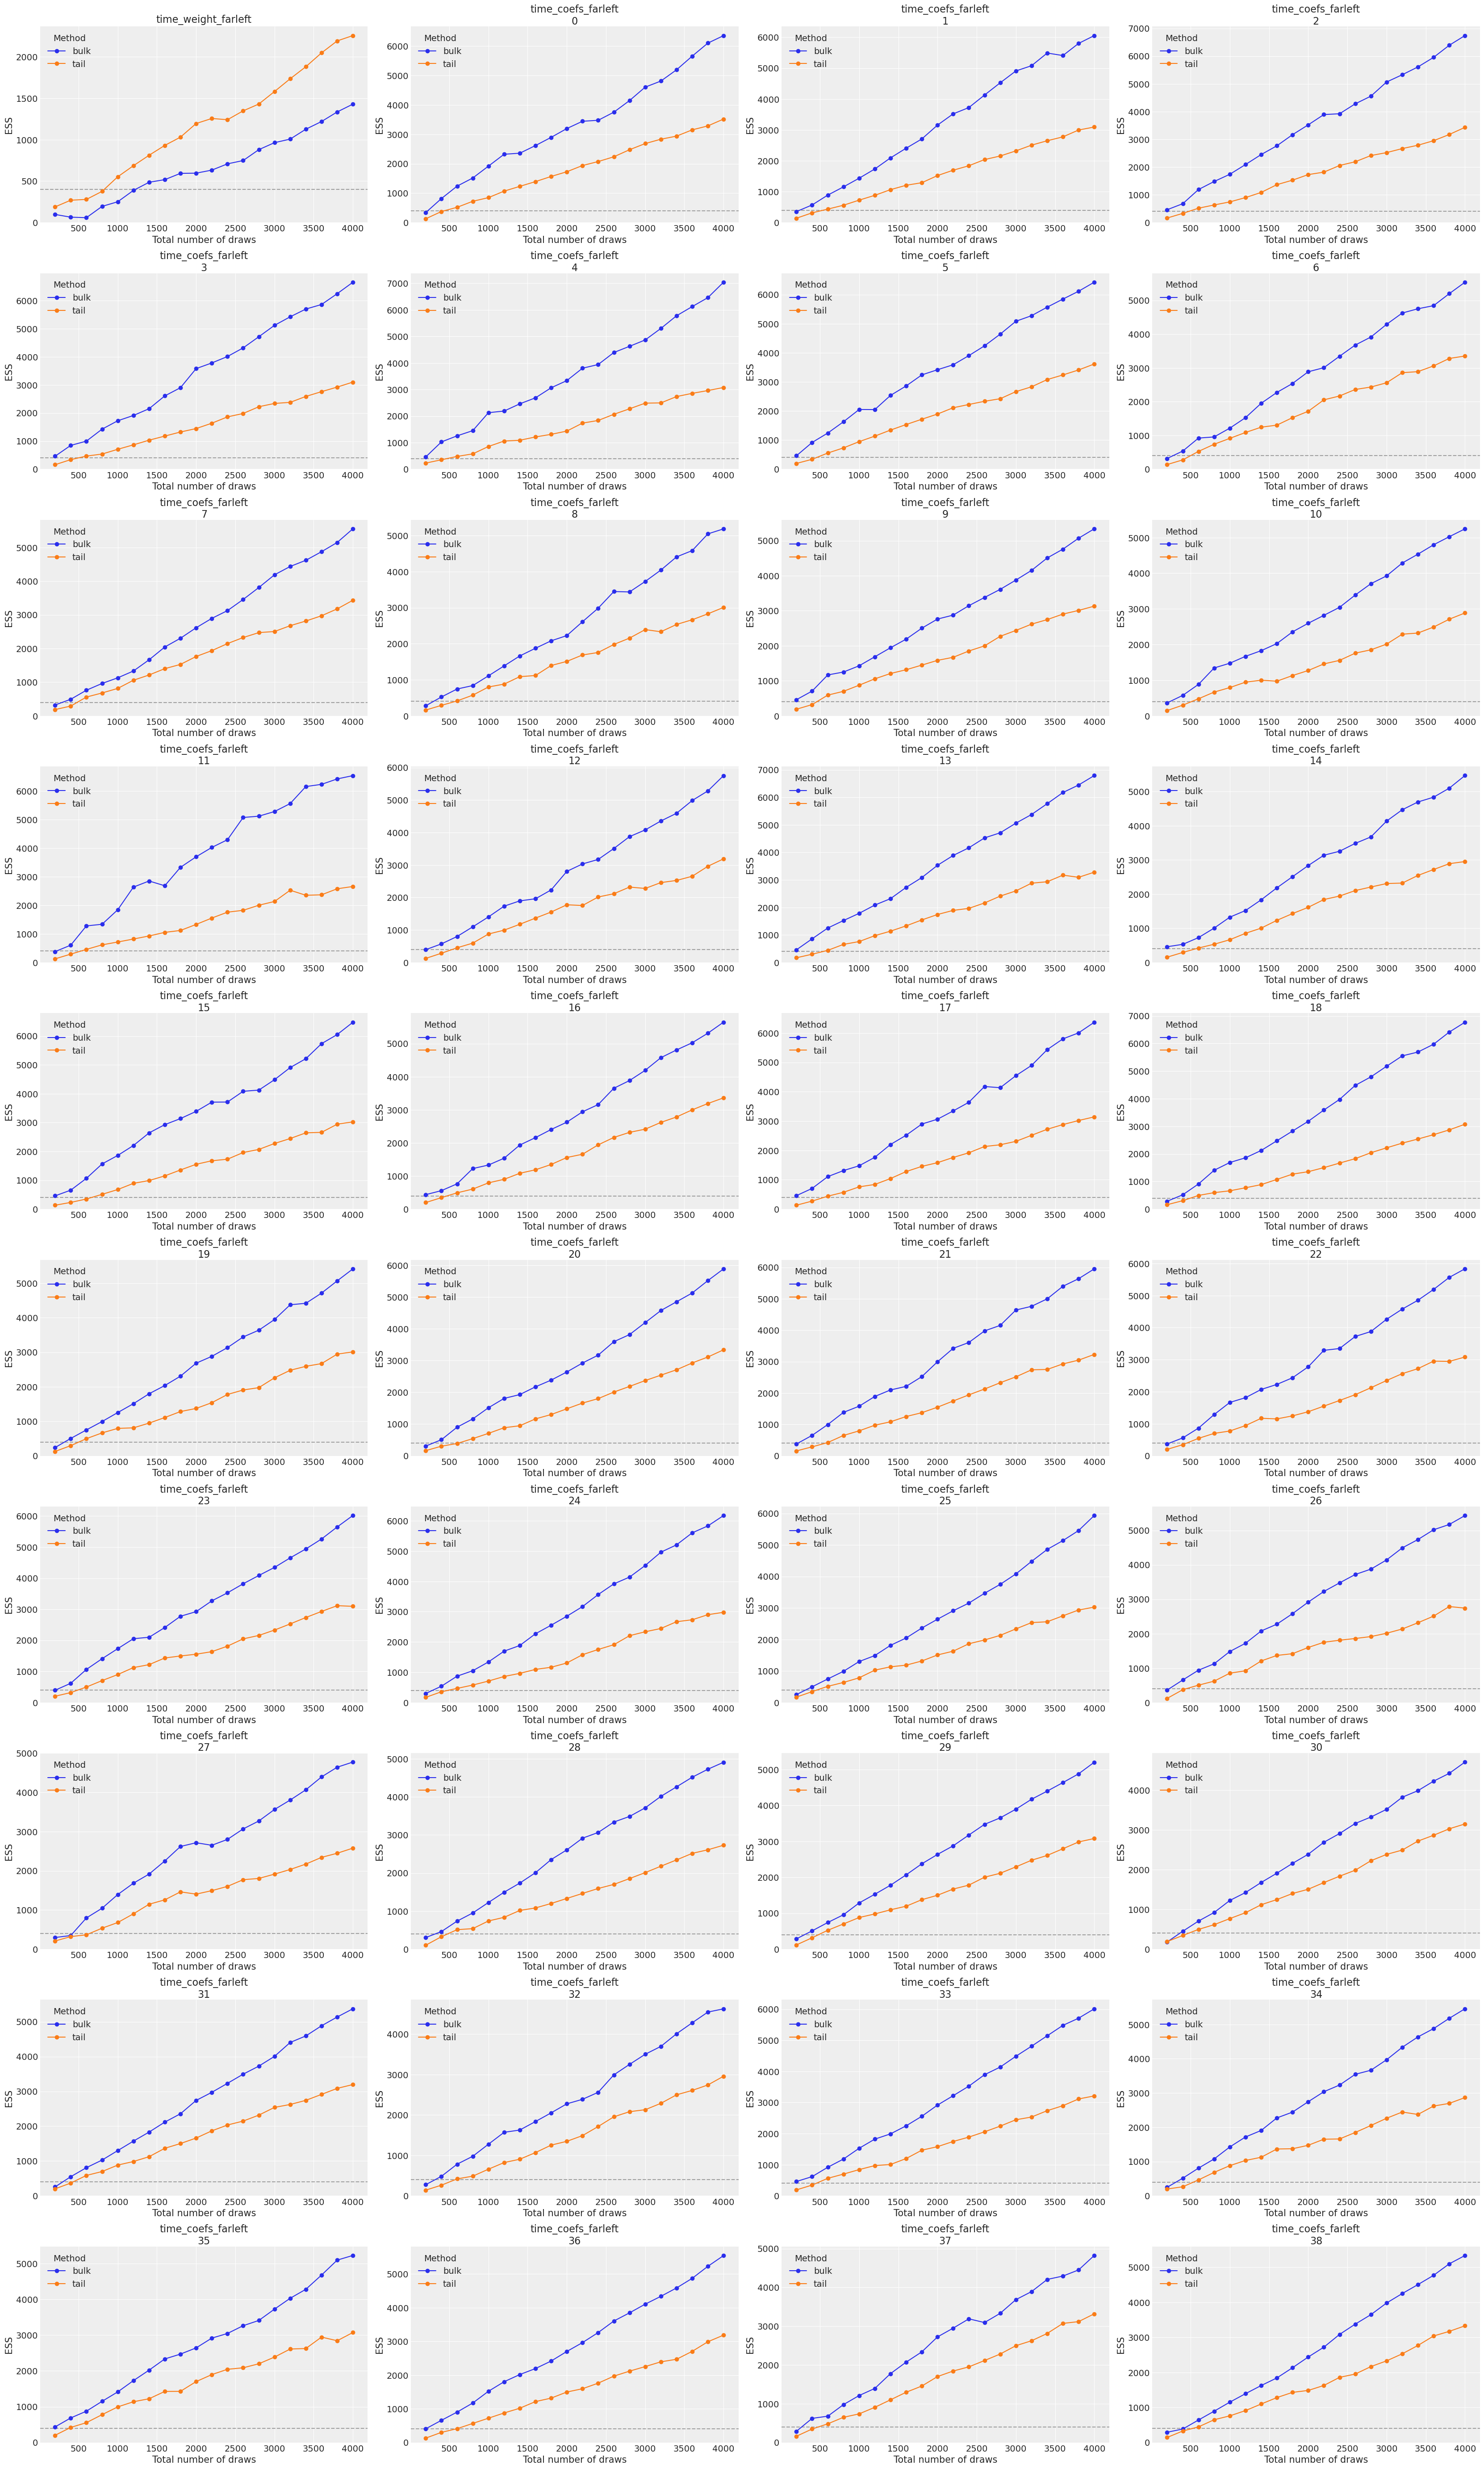

In [41]:
arviz.plot_ess(
    trace_simple,
    kind="evolution",
    var_names=["time_weight", "time_coefs"],
    filter_vars="regex",
);

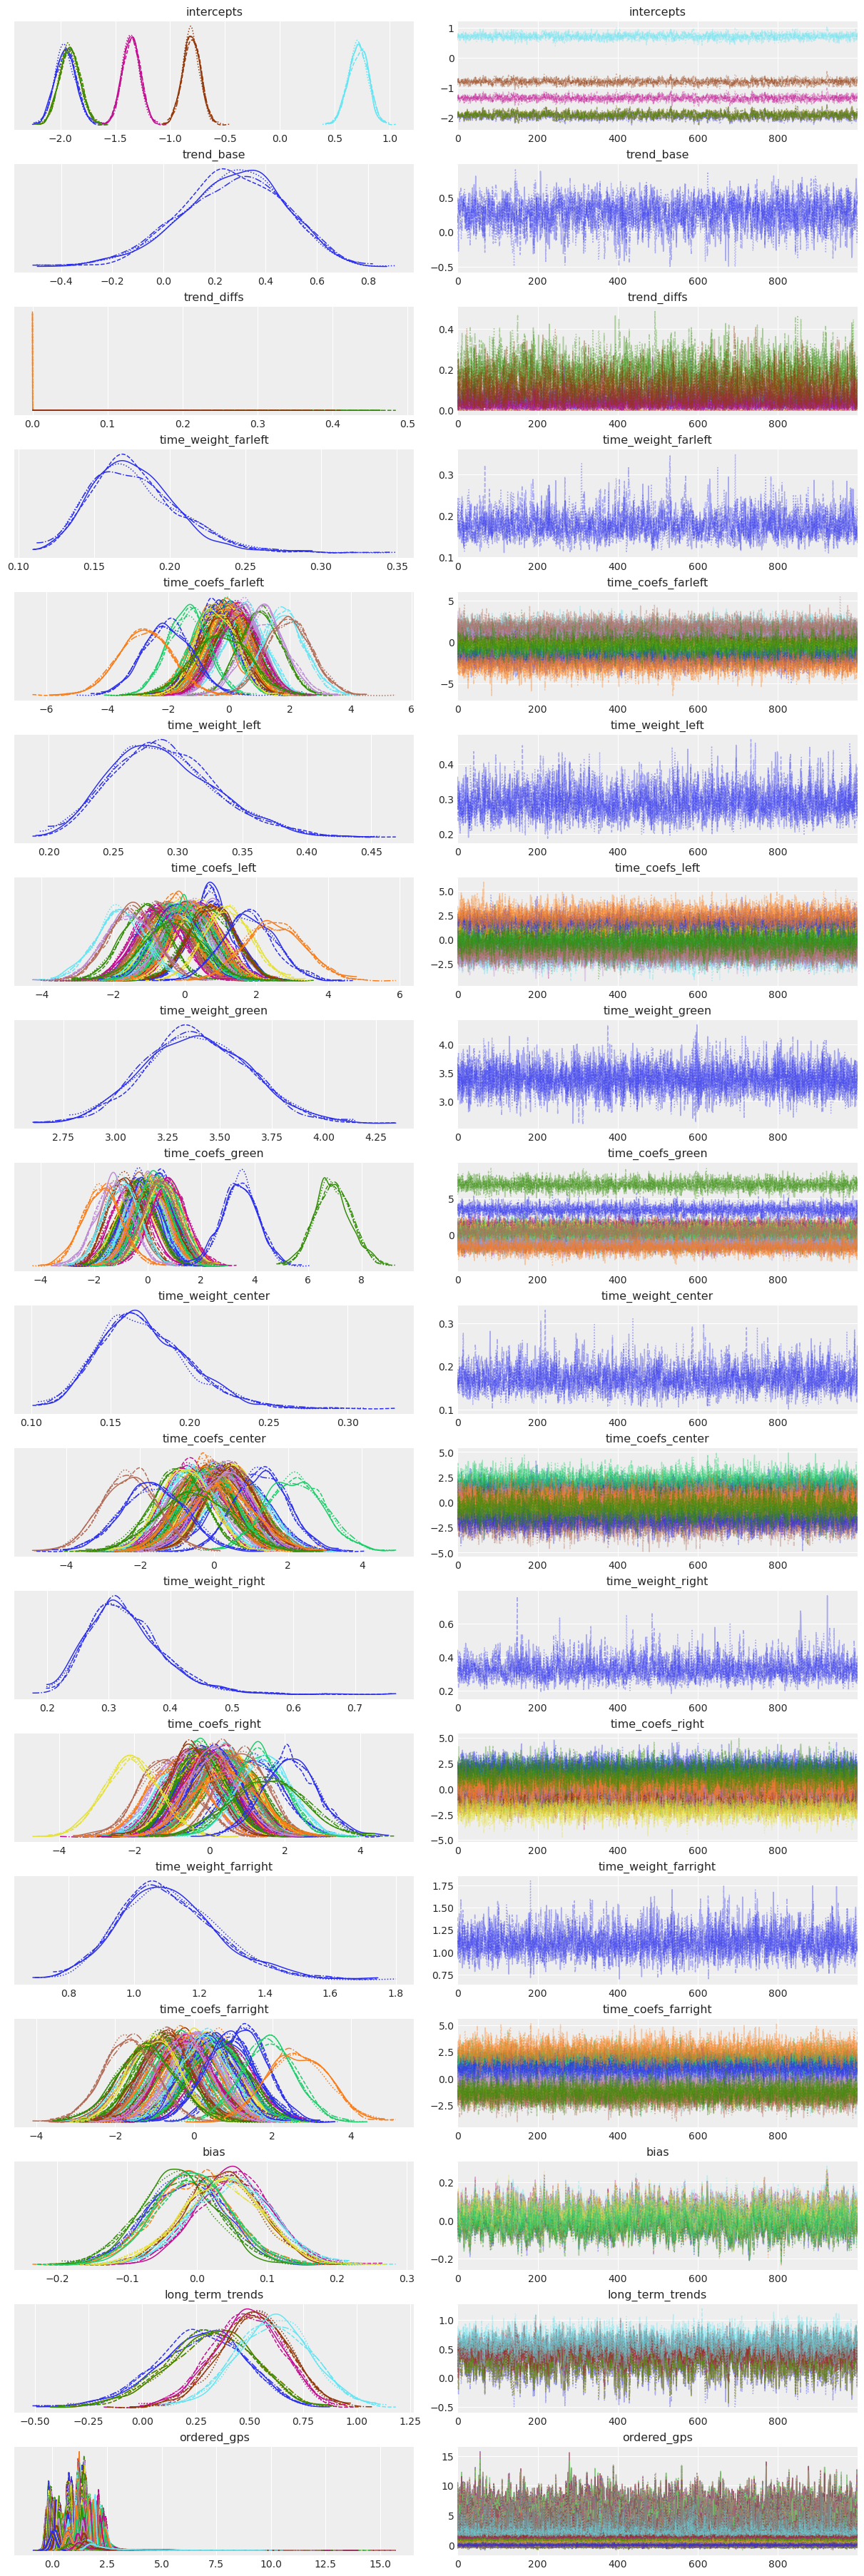

In [42]:
arviz.plot_trace(
    trace_simple,
    var_names=["ordered_gps", "~cutpoints", "~_diffs", "~time_effect", "~results_probs"],
    filter_vars="regex",
);

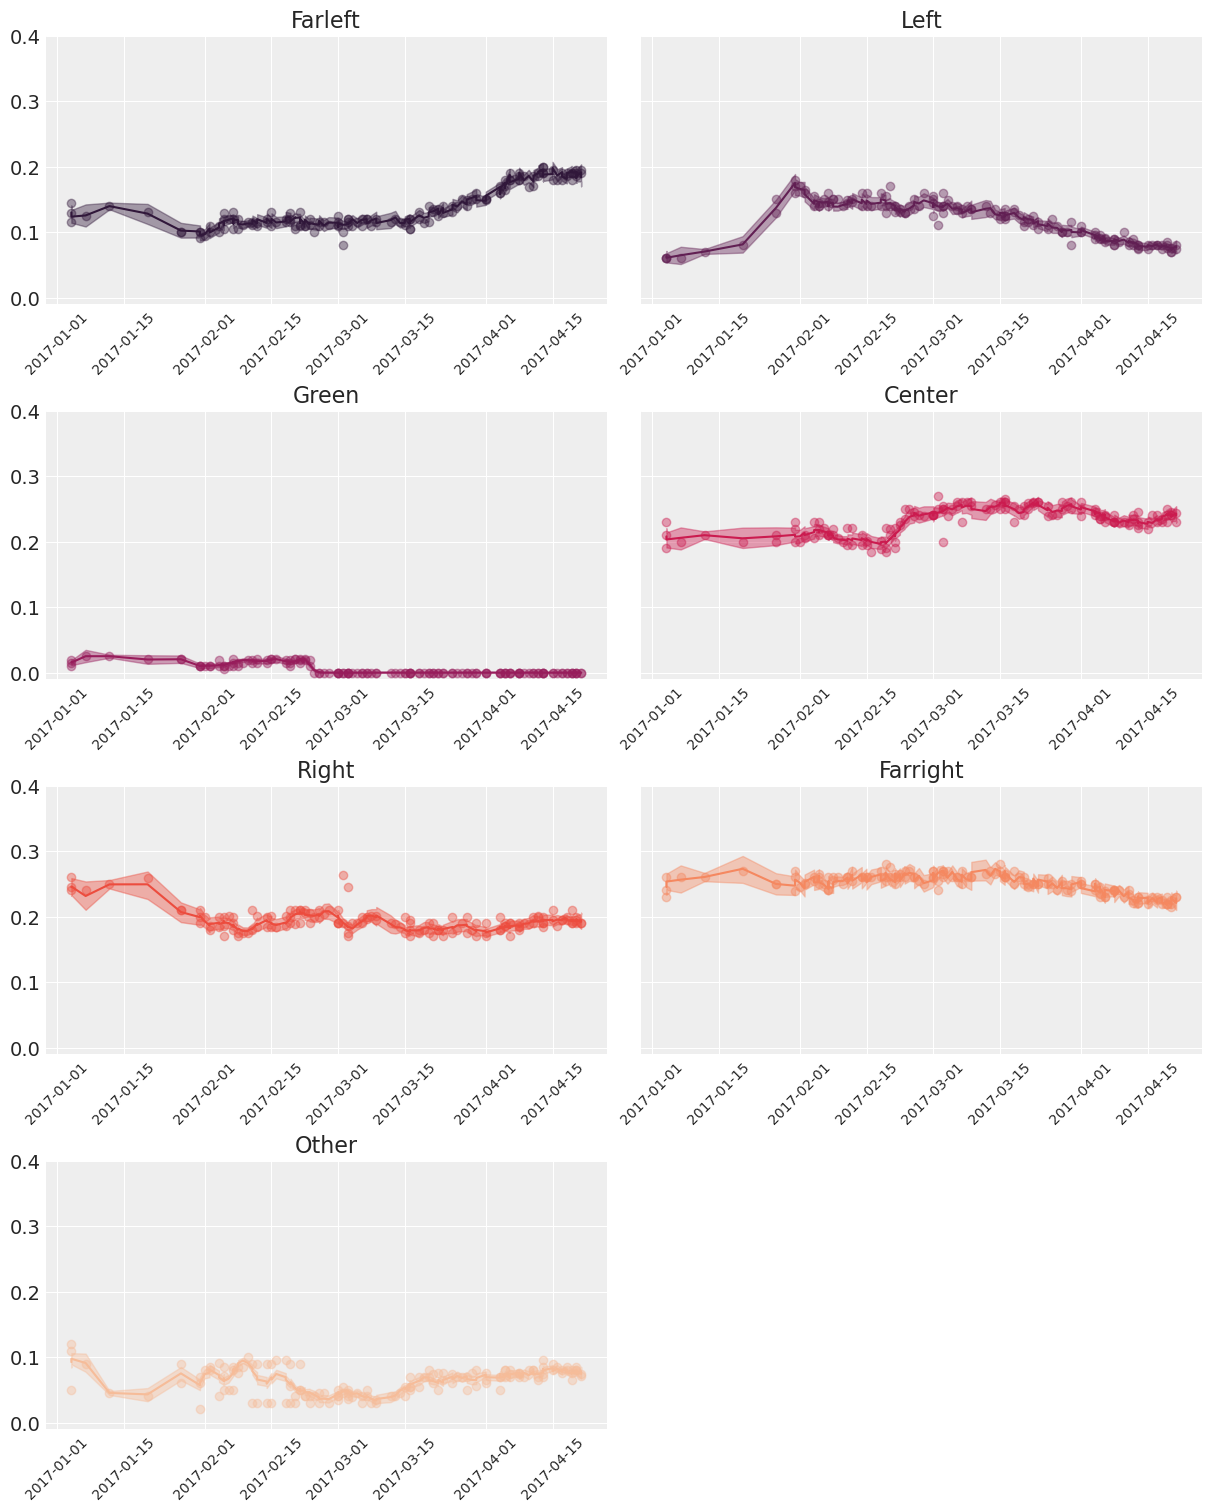

In [43]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
axes = axes.ravel()
axes[-1].remove()
colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

post_means = trace_simple.posterior["results_probs"].mean(("chain", "draw"))
hdi = arviz.hdi(trace_simple.posterior)

for i, p in enumerate(COORDS["parties_complete"]):
    axes[i].plot(
        polls["date"], polls[p] / polls["samplesize"], "o", color=colors[i], alpha=0.4
    )
    axes[i].fill_between(
        polls["date"],
        hdi.sel(parties_complete=p, hdi="lower")["results_probs"],
        hdi.sel(parties_complete=p, hdi="higher")["results_probs"],
        color=colors[i],
        alpha=0.4,
    )
    axes[i].plot(polls["date"], post_means.sel(parties_complete=p), color=colors[i])
    axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
    axes[i].set(title=p.title(), ylim=(-0.01, 0.4))

## Out-of-sample predictions

In [ ]:
trend = pm.Normal("long_term_trends")
t = pm.Data("t", observed_days_idx / observed_days_idx.max(), dims="observations")
eta = pm.Deterministic("eta", trend * t, dims="observations")

In [ ]:
t = pm.Data("t", estimated_days / estimated_days.max(), dims="estimated_days")

cutpoints = pm.Deterministic(
    "cutpoints",
    intercepts + aet.dot(t[:, None], trends[None, :]) + ordered_gps,
    dims=("estimated_days", "parties"),
)

bias = pm.Normal("bias", 0, 0.15, dims="pollsters")

In [44]:
p_cum = logistic(trace_simple.posterior["cutpoints"]).data
# post_eta = np.dot(trace_simple.posterior["long_term_trends"].data[..., None], estimated_days[None, ...])[..., None]
# p_cum = logistic(trace_simple.posterior["cutpoints"].data - post_eta)
p_cum = np.c_[
    np.zeros_like(p_cum[..., 0][..., None]),
    p_cum,
    np.ones_like(p_cum[..., 0][..., None]),
]
post_probs = xarray.DataArray(
    p_cum[..., 1:] - p_cum[..., :-1],
    dims=["chain", "draw", "estimated_days", "parties_complete"],
    coords={
        "chain": trace_simple.posterior["chain"],
        "draw": trace_simple.posterior["draw"],
        "estimated_days": trace_simple.posterior["estimated_days"],
        "parties_complete": trace_simple.posterior["parties_complete"],
    },
)

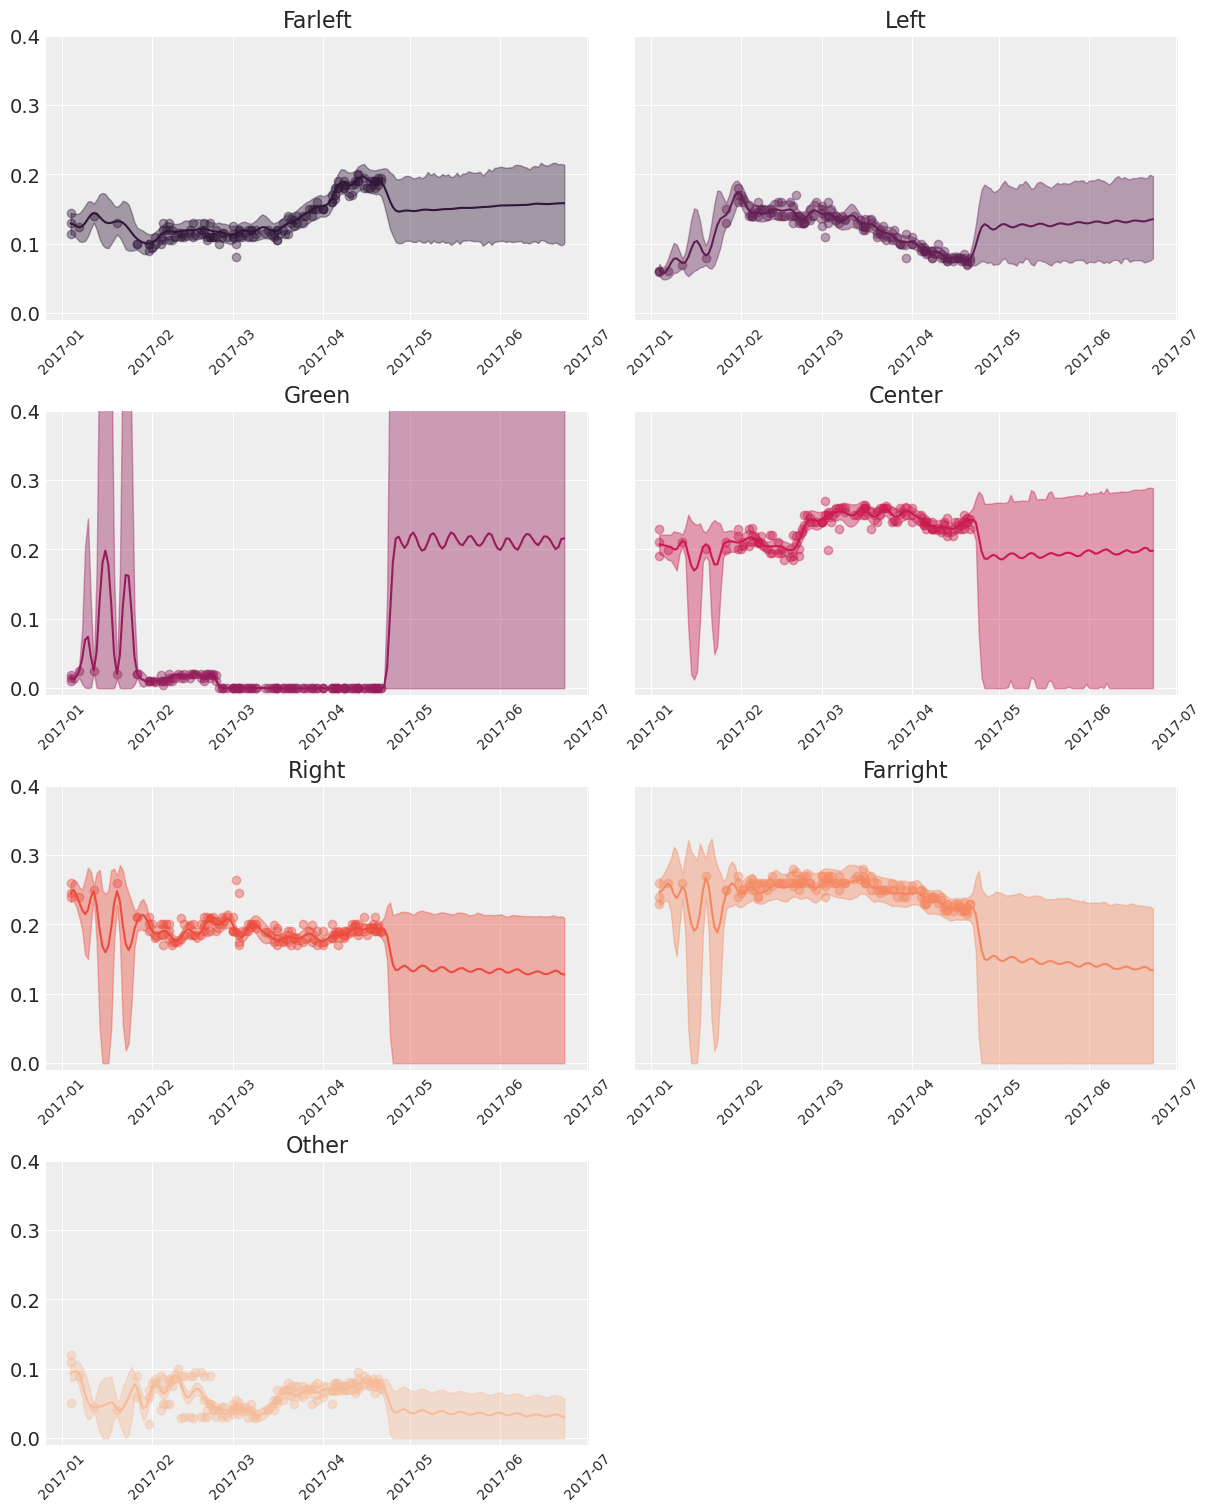

In [45]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
axes = axes.ravel()
axes[-1].remove()
colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

post_means = post_probs.mean(("chain", "draw"))
hdi = arviz.hdi(post_probs)

for i, p in enumerate(COORDS["parties_complete"]):
    axes[i].plot(
        polls["date"], polls[p] / polls["samplesize"], "o", color=colors[i], alpha=0.4
    )
    axes[i].fill_between(
        post_probs["estimated_days"],
        hdi.sel(parties_complete=p, hdi="lower")["x"],
        hdi.sel(parties_complete=p, hdi="higher")["x"],
        color=colors[i],
        alpha=0.4,
    )
    axes[i].plot(
        post_probs["estimated_days"],
        post_means.sel(parties_complete=p),
        color=colors[i],
    )
    axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
    axes[i].set(title=p.title(), ylim=(-0.01, 0.4))

In [ ]:
# GP reverting to fundamentals prior
# remove latest polls, predict up to election day (a week), compare to result and unobserved latest polls